In [130]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install pyserial
%pip install sympy
%pip install sounddevice

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [131]:
Fs = 50000
Ts = 1 / Fs

# Nw = int(noise_dur_s * Fs )
Nw = 2**14
# White noise length
noise_dur_s = Nw*Ts

silence_length = int(0/343 * Fs) # 20m worth of sample travel time
silence_length_s = silence_length * Ts

full_length = Nw + silence_length

cutoffs = [1000, 5000]


/tmp/ipykernel_8578/2177185214.py:47: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 10 * np.log10(np.abs(noise_fft)))


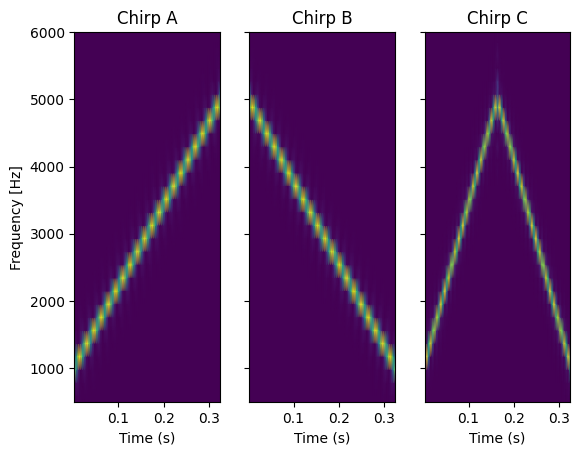

In [147]:
import scipy
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
## Generate noise

def make_linear_chirp(f0, f1, N, Ts):
  t = np.arange(N) * Ts

  c = (f1-f0)/(N*Ts)

  phi_0 = 0
  chirp = np.sin(phi_0 + 2*np.pi*(c/2*t*t+f0*t))
  return chirp


def make_hyperbolic_chirp(f0, f1, N, Ts):
  t = np.arange(N) * Ts

  phi_0 = 0
  chirp = np.sin(
      phi_0
        + 2*np.pi*(-f0*f1*noise_dur_s/(f1-f0))
        * np.log(1-(f1-f0)/f1/noise_dur_s*t)
  )
  return chirp

full = make_linear_chirp(cutoffs[0], cutoffs[1], Nw, Ts)
half = make_linear_chirp(cutoffs[0], cutoffs[1], Nw//2, Ts)

filtered_noiseA = full
filtered_noiseB = np.flip(full)
filtered_noiseC = np.concatenate((half, np.flip(half)))
#filtered_noiseD = np.concatenate((np.flip(half), half))
#print(max(filtered_noiseA))

def plot_spect(chirp):
  f, t, Sxx = scipy.signal.spectrogram(chirp, Fs)
  plt.pcolormesh(t, f, Sxx, shading='gouraud')
  plt.ylim([500, 6000])

def plot_freq(chirp):
  # plot noise
  noise_fft = sp.fft.rfft(chirp)
  n = len(noise_fft)
  f = np.arange(n) * Fs / n / 2
  plt.plot(f, 10 * np.log10(np.abs(noise_fft)))

plt.figure()
plt.subplot(131)
plot_spect(filtered_noiseA)
plt.xlabel('Time (s)')
plt.ylabel('Frequency [Hz]')
plt.title("Chirp A")
plt.subplot(132)
plot_spect(filtered_noiseB)
plt.title("Chirp B")
plt.xlabel('Time (s)')
plt.tick_params("y", labelleft=False)
plt.subplot(133)
plot_spect(filtered_noiseC)
plt.title("Chirp C")
plt.xlabel('Time (s)')
plt.tick_params("y", labelleft=False)

filtered_noiseA = np.concatenate((filtered_noiseA, np.zeros(silence_length)))
filtered_noiseB = np.concatenate((filtered_noiseB, np.zeros(silence_length)))
filtered_noiseC = np.concatenate((filtered_noiseC, np.zeros(silence_length)))

plt.figure(figsize=(100,100))
plt.subplot(131)
plot_freq(filtered_noiseA)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.subplot(132)
plot_freq(filtered_noiseB)
plt.subplot(133)
plot_freq(filtered_noiseC)



In [133]:
np.save("filtered_noiseA.npy", filtered_noiseA)
np.save("filtered_noiseB.npy", filtered_noiseB)
np.save("filtered_noiseC.npy", filtered_noiseC)

In [134]:
for (letter, noise) in [('A', filtered_noiseA), ('B', filtered_noiseB), ('C', filtered_noiseC)]:
    with open(f"../pico_play_noise/src/sound_samples/sound_samples{letter}.h", "w") as f:
        noise = np.copy(noise)
        noise *= 2**15-1
        noise = np.asarray(noise, dtype='int16')
        hexed = [f"{sample}" for sample in noise]
        f.write("#include <stddef.h> // for size_t\n")
        f.write("#include <stdint.h> // for uint16_t\n")
        f.write("\n")
        f.write(f"#define SOUND_SAMPLES_LEN {len(hexed)}\n")
        f.write("\n")
        f.write("//These are actually signed ints \n")
        f.write("const int16_t sound_samples[SOUND_SAMPLES_LEN] = {\n")
        for window in range(0, len(hexed), 10):
            s = "    " + ", ".join(hexed[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n")


In [135]:
import numpy as np
import matplotlib.pyplot as plt

def correlate_and_find_delay(rec, noise, name):
    # rec_padded = np.pad(rec, (len(noise), 0), 'constant', constant_values=0)
    # print(rec)
    rec_fft = np.fft.rfft(rec)
    diff = len(rec) - len(noise)
    assert diff == 0
    noise_padded = np.pad(noise, (0, diff), "constant", constant_values=0)
    noise_fft_conj = np.conj(np.fft.rfft(noise_padded))
    # print(rec_fft.shape, noise_fft_conj.shape)
    cross_corr_freq = noise_fft_conj * rec_fft
    cross_corr = np.abs(np.fft.irfft(cross_corr_freq))
    
    #valid_len = diff + 1
    #cross_corr = cross_corr[:valid_len]
    
    # print(cross_corr)
    plt.plot(cross_corr)
    plt.title("correlation " + name)

    k_max_ind = np.argmax(cross_corr)
    k_max = cross_corr[k_max_ind]
    avg = np.sum(cross_corr) / len(cross_corr)

    return k_max_ind, k_max, avg

indexes: 400 1000 1200
maxes: 8513.978347199234 8120.694293039825 8253.810935036498
avgs: 185.56778764408722 189.51471157480177 211.6031089869382
max/avg: 45.880691122581894 42.84994144021676 39.00609482796393


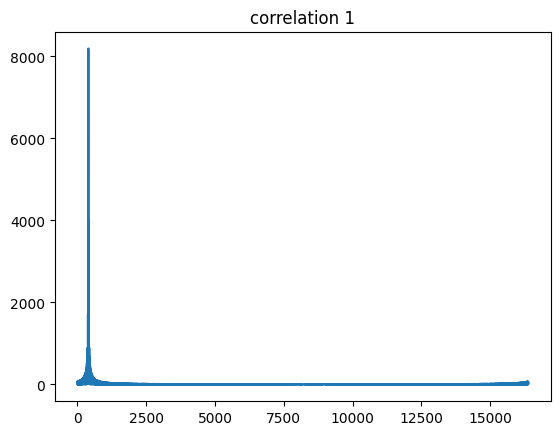

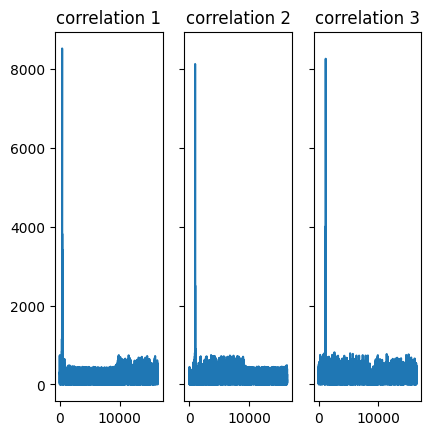

In [136]:
import numpy as np
import matplotlib.pyplot as plt

recording_noise_1 = np.zeros(full_length)
recording_noise_2 = np.zeros(full_length)
recording_noise_3 = np.zeros(full_length)

insert_loc = 400
# recording_noise_1[insert_loc : insert_loc + Nw] += filtered_noise1
recording_noise_1 = np.roll(filtered_noiseA, insert_loc)
insert_loc2 = 1000
# recording_noise_2[insert_loc2 : insert_loc2 + Nw] += filtered_noise2
recording_noise_2 = np.roll(filtered_noiseB, insert_loc2)
insert_loc3 = 1200
# recording_noise_3[insert_loc3 : insert_loc3 + Nw] += filtered_noise3
recording_noise_3 = np.roll(filtered_noiseC, insert_loc3)

recording_noise_together = recording_noise_1 + recording_noise_2 + recording_noise_3 
# recording_noise_together = recording_noise_together / max(recording_noise_together)

plt.figure()
ind1 = correlate_and_find_delay(recording_noise_1, filtered_noiseA, "1")
plt.figure()
ax1 = plt.subplot(141)
ind1, max1, avg1 = correlate_and_find_delay(recording_noise_together, filtered_noiseA, "1")
plt.subplot(142, sharey=ax1)

ind2, max2, avg2 = correlate_and_find_delay(recording_noise_together, filtered_noiseB, "2")
plt.tick_params("y", labelleft=False)
plt.subplot(143, sharey=ax1)
ind3, max3, avg3 = correlate_and_find_delay(recording_noise_together, filtered_noiseC, "3")
plt.tick_params("y", labelleft=False)
print("indexes:", ind1, ind2, ind3)
print("maxes:", max1, max2, max3)
print("avgs:", avg1, avg2, avg3)
print("max/avg:", max1/avg1, max2/avg2, max3/avg3)

728
[5.000005   4.99999167] [-1.38036441e-03  6.66762694e+00]
[[ 5.00000500e+00 -1.38036441e-03]
 [ 4.99999167e+00  6.66762694e+00]]
[9.468777038250959e-08, 50.02663864976283]


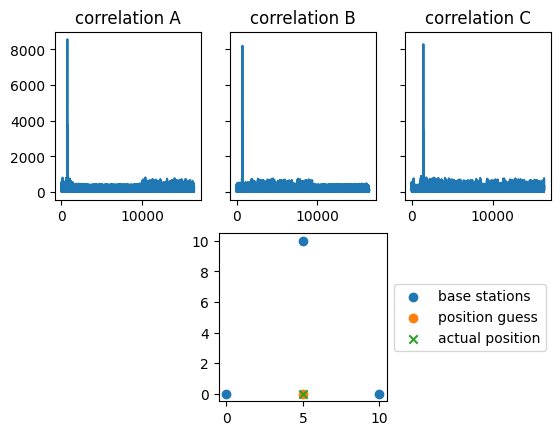

In [137]:
### Time Difference of Arrival with 3 nodes

A = np.array([0, 0])
B = np.array([10, 0])
C = np.array([5, 10])

actual_position = np.array([5, 0])

delay1 = int(abs(np.linalg.norm(A - actual_position)) * Fs // 343)
delay2 = int(abs(np.linalg.norm(B - actual_position)) * Fs // 343)
delay3 = int(abs(np.linalg.norm(C - actual_position)) * Fs // 343)

recording_noise = np.zeros(full_length)
print(delay1)
#recording_noise[delay1 : delay1 + Nw] += filtered_noise1
recording_noise += np.roll(filtered_noiseA, delay1)
#recording_noise[delay2 : delay2 + Nw] += filtered_noise2
recording_noise += np.roll(filtered_noiseB, delay2)
#recording_noise[delay3 : delay3 + Nw] += filtered_noise3
recording_noise += np.roll(filtered_noiseC, delay3)


def fangs_algorithm_TDoA(ta, tb, tc):
    ## Fang's algorithm, gotten from the PDF (in the repo or at https://ieeexplore.ieee.org/document/102710)
    assert A[0] == 0 and A[1] == 0
    assert B[0] > 0 and B[1] == 0
    assert C[1] > 0

    c = 343  # speed of wave in medium, speed of sound=343 m/s

    cTa = ta * c
    cTb = tb * c
    cTc = tc * c

    b = B[0]  # also = np.linalg.norm(B)
    cx = C[0]
    cy = C[1]
    c = np.linalg.norm(C)

    Rab = cTa - cTb
    Rac = cTa - cTc

    #avoid division by zero, just make em real small
    if Rab == 0.0:
        Rab = 1e-5
    if Rac == 0.0:
        Rac = 1e-5

    # variable names correspond to those in the paper

    g = (Rac * b / Rab - cx) / cy
    h = (c**2 - Rac**2 + Rac * Rab * (1 - (b / Rab) ** 2)) / (2 * cy)

    d = -(1 - (b / Rab) ** 2 + g**2)
    e = b * (1 - (b / Rab) ** 2) - 2 * g * h
    f = (Rab**2 / 4) * (1 - (b / Rab) ** 2) ** 2 - h**2

    z = 0
    x = np.roots([d, e, f - z**2])  # eq 9a
    y = g * x + h  # eq 13
    print(x, y)

    guesses = np.transpose([x, y])
    print(guesses)

    def err(g):
        # calculate what sort of time deltas would be seen with this guess
        # compare them to the original, return the MSE
        deltaA = np.linalg.norm(g - A)
        deltaB = np.linalg.norm(g - B)
        deltaC = np.linalg.norm(g - C)
        rab = deltaA - deltaB
        rac = deltaA - deltaC
        mse = ((rab - Rab) ** 2 + (rac - Rac) ** 2) / 2
        return mse
    errs = [err(a) for a in guesses]
    print(errs)

    best_guess = min(guesses, key=err)
    return best_guess


plt.figure()
ax1 = plt.subplot(231)
found_delay1, max1, avg1 = correlate_and_find_delay(recording_noise, filtered_noiseA, "A")
plt.subplot(232, sharey=ax1)
found_delay2, max2, avg2 = correlate_and_find_delay(recording_noise, filtered_noiseB, "B")
plt.tick_params('y', labelleft=False)
plt.subplot(233, sharey=ax1)
found_delay3, max3, avg3 = correlate_and_find_delay(recording_noise, filtered_noiseC, "C")
plt.tick_params('y', labelleft=False)

ta = found_delay1 / Fs
tb = found_delay2 / Fs
tc = found_delay3 / Fs

guessed_position = fangs_algorithm_TDoA(ta, tb, tc)
plt.subplot(212)
plt.scatter([A[0], B[0], C[0]], [A[1], B[1], C[1]], label="base stations", marker="o")
plt.scatter(guessed_position[0], guessed_position[1], label="position guess")
plt.scatter(actual_position[0], actual_position[1], label="actual position", marker="x")
plt.gca().set_aspect("equal")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

In [138]:
import sounddevice as sd

data = filtered_noiseA# + filtered_noiseB + filtered_noiseC
#data /= 3
data = np.pad(data, (0,full_length*1000), 'wrap').reshape(-1,1)

sd.play(data, samplerate=Fs, blocking=True, loop=False, device="default")

KeyboardInterrupt: 

In [ ]:
import serial
import scipy as sp
import numpy as np 

fs, samples = sp.io.wavfile.read("song3.wav")
samples = samples // 8
print(fs, samples.dtype)
assert(samples.dtype == np.int16)
sample_bytes = samples.tobytes()

ser = serial.Serial("/dev/ttyACM1", 115200)
ser.write(sample_bytes)
ser.flush()
print("done")

In [ ]:
import serial
import scipy as sp
import numpy as np 

ser = serial.Serial("/dev/ttyACM1", 115200)
ser.write(b"r")
b = ser.read(48000 * 2 * 5)

#samples = np.frombuffer(b, dtype=np.uint32)
#samples = (samples)
#samples = np.frombuffer(samples.tobytes(), dtype=np.int32)
samples = np.frombuffer(b, dtype=np.int16)
import sounddevice as sd

sd.play(samples, 48000)
sd.wait()
for i in samples:
    print(hex(i))

In [ ]:
# Used with pico_record_noise, plays the sound samples as they are received
import serial
import sounddevice as sd
import numpy as np
import multiprocessing

def record_from_serial(num_samples):
    with serial.Serial("/dev/ttyACM0", 115200) as ser:
        # ser.set_buffer_size(rx_size = 8192)
        ser.write(b"freq\n")
        #print(ser.readline())
        ser.write(f"{Fs}\n".encode())
        #print(ser.readline())
        #num_samples = int(Fs)
        ser.write(f"{num_samples}\n".encode())
        #print(size)
        num_bytes = num_samples*2 # 2 bytes per sample
        b = ser.read(num_bytes)
        data = np.frombuffer(b, dtype="<i2")
        return data

#sound = record_from_serial(Fs)
#sd.play(sound,samplerate=Fs)

50000


50000


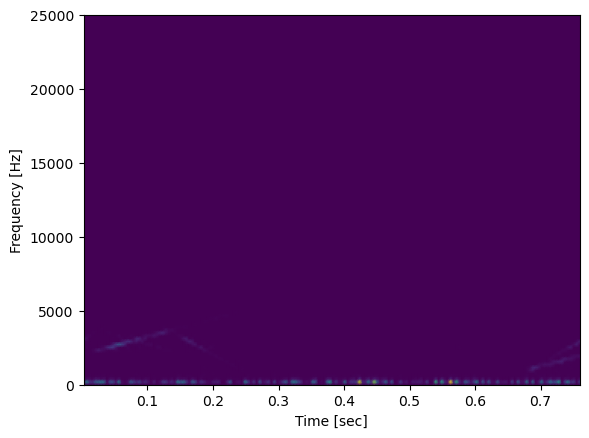

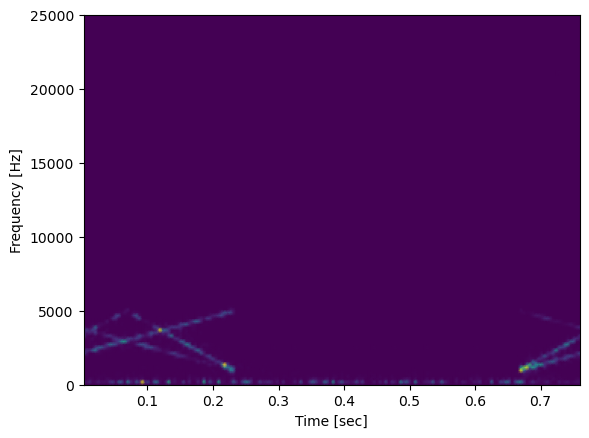

In [ ]:
import sounddevice as sd

sound_mic = sd.rec(full_length*2, samplerate=fs, blocking=True, channels=1)[full_length:]
sound_pico = record_from_serial(full_length)
plot_spect(sound_mic.flatten())
plt.figure()
plot_spect(sound_pico)
#plt.plot(sound)
#plt.figure()
#plt.plot(filtered_noiseA)
#sd.play(sound, device="default", blocking=True, samplerate=Fs)

(38249,)


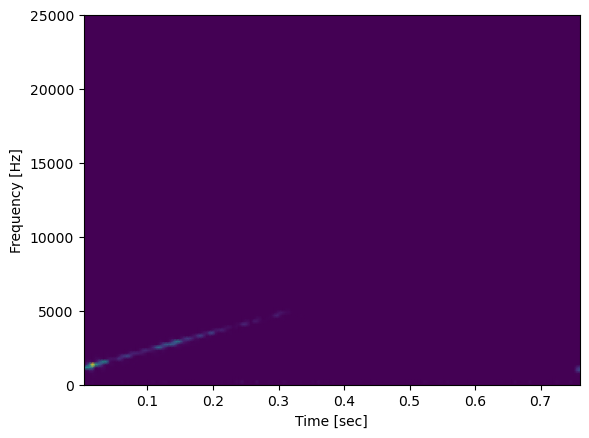

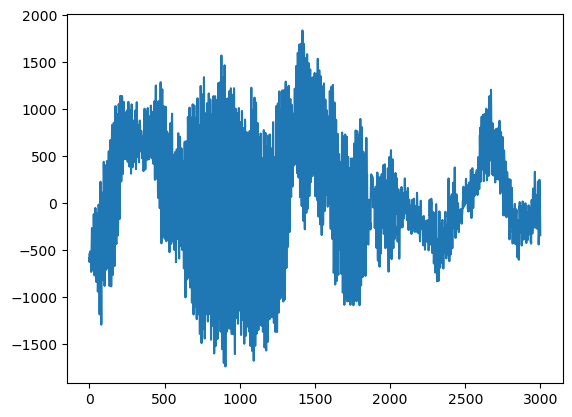

In [ ]:
#sd.play(sound, device="default", blocking=True, samplerate=Fs)
#print(sound.shape)
plot_spect(sound)
plt.figure()
plt.plot(sound[14000:17000])


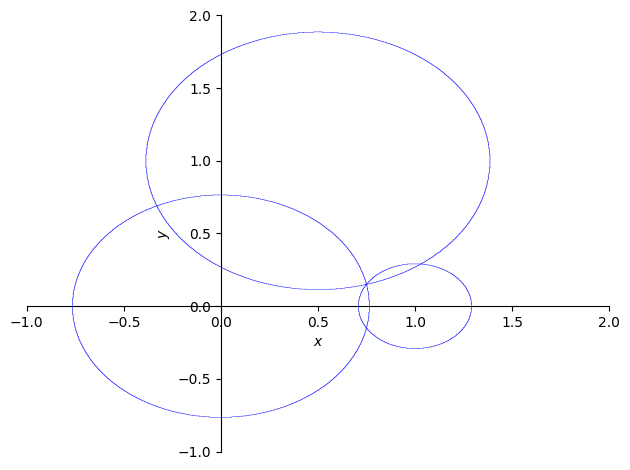

In [146]:
from sympy import plot_implicit, symbols, Eq, sqrt

x, y = symbols('x y')

A = (0,0)
B = (1,0)
C = (0.5,1)

p = (0.75, 0.15)

R_A = sqrt((p[0]-A[0])**2 + (p[1]-A[1])**2)
R_B = sqrt((p[0]-B[0])**2 + (p[1]-B[1])**2)
R_C = sqrt((p[0]-C[0])**2 + (p[1]-C[1])**2)

p1 = plot_implicit(Eq(sqrt((A[0]-x)**2 + (A[1]-y)**2), R_A), (x, -1, 2), (y, -1, 2), show=False)
p2 = plot_implicit(Eq(sqrt((B[0]-x)**2 + (B[1]-y)**2), R_B), (x, -1, 2), (y, -1, 2), show=False)
p3 = plot_implicit(Eq(sqrt((C[0]-x)**2 + (C[1]-y)**2), R_C), (x, -1, 2), (y, -1, 2), show=False)
p1.append(p2[0])
p1.append(p3[0])
p1.show()

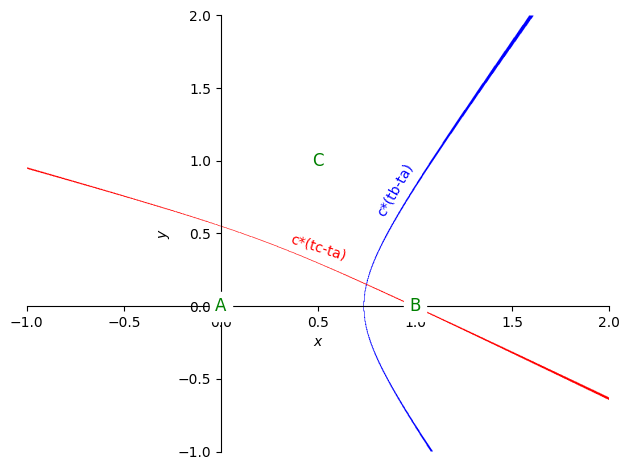

In [ ]:
import matplotlib.pyplot as plt


c = 343
ta = R_A/c
tb = R_B/c
tc = R_C/c

p2 = plot_implicit(Eq(sqrt((B[0]-x)**2 + (B[1]-y)**2)-sqrt((A[0]-x)**2 + (A[1]-y)**2), c*(tb-ta)), (x, -1, 2), (y, -1, 2), show=False, line_color="b",
                   annotations=[{'xy': (A[0], A[1]), 'text': "A", 'ha': 'center', 'va': 'center', 'color': 'green', 'size': 'large', 'backgroundcolor':'white'},
                                {'xy': (B[0], B[1]), 'text': "B", 'ha': 'center', 'va': 'center', 'color': 'green', 'size': 'large', 'backgroundcolor':'white'},
                                {'xy': (C[0], C[1]), 'text': "C", 'ha': 'center', 'va': 'center', 'color': 'green', 'size': 'large', 'backgroundcolor':'white'},
                                {'xy': (0.5, 0.40),   'text': "c*(tc-ta)", 'rotation': -18.0, 'ha': 'center', 'va': 'center', 'color': 'red'},
                                {'xy': (0.90, 0.8), 'text': "c*(tb-ta)", 'rotation': 60.0, 'ha': 'center', 'va': 'center', 'color': 'blue'},]
)
p3 = plot_implicit(Eq(sqrt((C[0]-x)**2 + (C[1]-y)**2)-sqrt((A[0]-x)**2 + (A[1]-y)**2), c*(tc-ta)), (x, -1, 2), (y, -1, 2),show=False, line_color="r")
p2.append(p3[0])

p2.show()




